# La evolución del COVID-19 en Uruguay en mapas animados

**Javier Orman**  
LinkedIn: https://www.linkedin.com/in/javierorman/  
GitHub del Notebook: https://github.com/javierorman/choromap/tree/master/covid19_uruguay


(Última actualización: 7/12/2020)

### Introducción

El virus COVID-19, llamado así por sus siglas en inglés (Coronavirus Disease 2019), ha afectado a todos los países del mundo y Uruguay no es excepción. El virus ha afectado a cada departamento de forma desigual y las visualizaciones de datos pueden ayudar a observar este proceso de forma intuitiva.

En este notebook, a partir de los datos publicados por el Sistema Nacional de Emergencias de Uruguay y disponibles en el [catálogo de datos abiertos](https://catalogodatos.gub.uy/), se utiliza la herramienta "choromap" (repositorio en GitHub [aquí](https://github.com/javierorman/choromap)) para construir mapas animados que visibilicen la evolución de la distribución territorial de los casos detectados.

### Índice

[1. Datos de COVID-19 de Uruguay](#section_1)  
[2. Datos demográficos](#section_2)  
[3. Datos geográficos](#section_3)  
[4. Total de casos activos](#section_4)  
[5. Tasa de casos activos](#section_5)  
[6. Total de fallecidos](#section_6)  
[7. Tasa de fallecidos](#section_7)  

### Dependencias

Los datos van a ser importados y organizados con pandas. 
Geopandas va a permitir trabajar con datos geoespaciales y las visualizaciones van a ser realizadas con matplotlib.

In [1]:
import pandas as pd
import geopandas as gpd

import requests

import os
import sys

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

Importamos la clase *ChoroMapBuilder* y *DataFramePrepper* del módulo *choromap*.

In [3]:
from choromap import ChoroMapBuilder, DataFramePrepper

<a id='section_1'></a>

## Datos

### 1. Datos de COVID-19 en Uruguay

Los datos provistos por el Sistema Nacional de Emergencias están disponibles en el [Catálogo Nacional](https://catalogodatos.gub.uy/dataset/sinae01-covid19) y son accesibles mediante API.

In [4]:
url = 'http://catalogodatos.gub.uy/api/3/action/datastore_search?resource_id=a9dbbd4e-9cf3-4bed-943f-c5e133543673'

# initialize empty dataframe
uru_df = pd.DataFrame(columns=['Fecha', 'Indicador', 'Territorio', 'Valor'])

while True:
    # make request
    r = requests.get(url, verify=False)
    response = r.json()
    
    # get new data
    data = response['result']['records']
    if not data:
        break
    
    # add new data to dataframe
    df_temp = pd.DataFrame(data, columns=['Fecha', 'Indicador', 'Territorio', 'Valor'])
    uru_df = pd.concat([uru_df, df_temp], ignore_index=True)
    
    # get url for next request
    next_url = response['result']['_links']['next']
    url = 'http://catalogodatos.gub.uy' + next_url

In [6]:
uru_df

,Unnamed: 0,Fecha,Indicador,Territorio,Valor
0,0,2020-04-09T00:00:00,Casos activos,Artigas,0
1,1,2020-04-09T00:00:00,Casos activos,Canelones,37
2,2,2020-04-09T00:00:00,Casos activos,Cerro Largo,0
3,3,2020-04-09T00:00:00,Casos activos,Colonia,4
4,4,2020-04-09T00:00:00,Casos activos,Durazno,0
...,...,...,...,...,...
15539,15539,2020-11-24T00:00:00,Cantidad de Tests,Todo el país,0
15540,15540,2020-11-24T00:00:00,Personas en CTI,Todo el país,13
15541,15541,2020-11-24T00:00:00,Personas en CI,Todo el país,0
15542,15542,2020-11-24T00:00:00,Fallecidos,Todo el país,72


In [7]:
uru_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15544 entries, 0 to 15543
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  15544 non-null  int64 
 1   Fecha       15544 non-null  object
 2   Indicador   15544 non-null  object
 3   Territorio  15544 non-null  object
 4   Valor       15544 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 607.3+ KB


Aquí vemos información de las 4 columnas, el tipo de datos que contienen y el número de filas con campos vacíos (0 en este caso). Vamos a cambiar el tipo de datos de la columna 'Valor' a *type* numérico.

In [8]:
# Cambiar el tipo de la columna 'Valor' a int32
uru_df['Valor'] = uru_df['Valor'].astype('int32')

# Limpiar fechas
uru_df['Fecha'] = uru_df['Fecha'].str.slice(0, 10)

# Quitar filas con valores de 'Todo el país'
uru_df = uru_df[uru_df['Territorio'] != 'Todo el país']
uru_df.reset_index(drop=True, inplace=True)

# Eliminar espacios innecesarios
uru_df.Indicador = uru_df.Indicador.str.replace('\xa0', '')
uru_df.Territorio = uru_df.Territorio.str.replace('\xa0', '')
uru_df.Indicador = uru_df.Indicador.str.replace('  ', ' ')

Observamos las categorías presentes en "Indicadores":

In [9]:
uru_df.Indicador.unique()

array(['Casos activos', 'Casos recuperados', 'Fallecidos'], dtype=object)

<a id='section_2'></a>

### 2. Datos demográficos

Además de los números absolutos, queremos trabajar con tasas de casos activos y de fallecidos en proporción a la población de cada departamento. Para eso importamos a continuación [datos del Insituto Nacional de Estadística](http://www.ine.gub.uy/censos-1852-2011).  
Interesan los datos de la última columna, correspondiente a la población de cada departamente de acuerdo al Censo 2011.

In [10]:
pobl_df = pd.read_excel('datasets/Censos_T4.xls')

# Las primeras 10 filas
pobl_df.head(10)

,Poblacion en el pais segun departamento,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,"Censos de Población años 1852, 1860, 1908, 196...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Departametno,1852,1860,1908.0,1963.0,1975.0,1985.0,1996.0,2004.0,2011 (1)
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Total del País,131969,229480,1042686.0,2595510.0,2788429.0,2955241.0,3163763.0,3241003.0,3286314
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Montevideo,33994,57913,309231.0,1202757.0,1237227.0,1311976.0,1344839.0,1325968.0,1319108
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Resto País,97975,171567,733455.0,1392753.0,1551202.0,1643265.0,1818924.0,1915035.0,1967206


Quitamos filas innecesarias:

In [11]:
pobl_df = pobl_df.iloc[7:]
pobl_df.drop(index=[8, 9, 10], inplace=True)
pobl_df = pobl_df.loc[:28]
pobl_df.reset_index(inplace=True, drop=True)

In [12]:
# Las primeras 5 filas
pobl_df.head()

,Poblacion en el pais segun departamento,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Montevideo,33994,57913,309231.0,1202757.0,1237227.0,1311976.0,1344839.0,1325968.0,1319108
1,Artigas,(a),(a),26321.0,52843.0,57947.0,69145.0,75059.0,78019.0,73378
2,Canelones,17817,20468,87874.0,258195.0,325594.0,364248.0,443053.0,485240.0,520187
3,Cerro Largo,6451,17475,44742.0,71023.0,74027.0,78416.0,82510.0,86564.0,84698
4,Colonia,7971,13349,54644.0,105276.0,111832.0,112717.0,120241.0,119266.0,123203


Removemos columnas innecesarias y nombramos las dos que nos interesan.

In [13]:
pobl_df.rename(columns={'Poblacion en el pais segun departamento': 'Territorio', 'Unnamed: 9': 'Pobl'}, inplace=True)
pobl_df = pobl_df[['Territorio', 'Pobl']]
pobl_df.iloc[11, 0] = 'Río Negro'

In [14]:
# La tabla completa
pobl_df

,Territorio,Pobl
0,Montevideo,1319108
1,Artigas,73378
2,Canelones,520187
3,Cerro Largo,84698
4,Colonia,123203
5,Durazno,57088
6,Flores,25050
7,Florida,67048
8,Lavalleja,58815
9,Maldonado,164300


In [15]:
pobl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Territorio  19 non-null     object
 1   Pobl        19 non-null     object
dtypes: object(2)
memory usage: 432.0+ bytes


La columna "Pobl" debería ser de tipo numérico:

In [16]:
pobl_df['Pobl'] = pobl_df['Pobl'].astype('int32')

In [17]:
pobl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Territorio  19 non-null     object
 1   Pobl        19 non-null     int32 
dtypes: int32(1), object(1)
memory usage: 356.0+ bytes


Combinamos las dos tablas (datos de COVID-19 y datos demográficos):

In [18]:
uru_pobl_df = uru_df.merge(pobl_df, on='Territorio', how='inner')

In [19]:
uru_pobl_df

,Unnamed: 0,Fecha,Indicador,Territorio,Valor,Pobl
0,0,2020-04-09,Casos activos,Artigas,0,73378
1,19,2020-04-09,Casos recuperados,Artigas,0,73378
2,38,2020-04-09,Fallecidos,Artigas,0,73378
3,67,2020-04-10,Casos activos,Artigas,0,73378
4,86,2020-04-10,Casos recuperados,Artigas,0,73378
...,...,...,...,...,...,...
13219,15443,2020-11-23,Casos activos,Treinta y Tres,1,48134
13220,15462,2020-11-23,Casos recuperados,Treinta y Tres,113,48134
13221,15481,2020-11-23,Fallecidos,Treinta y Tres,2,48134
13222,15510,2020-11-24,Casos activos,Treinta y Tres,1,48134


Agregamos la columna "Valor_tasa" a partir de las columnas "Valor" y "Pobl". De esta manera, podemos graficar con datos de población afectada en proporción a la población de cada departamento.

In [20]:
tasa = 100000
uru_pobl_df['Valor_tasa'] = (uru_pobl_df['Valor'] / uru_pobl_df['Pobl']) * tasa

In [21]:
uru_pobl_df

,Unnamed: 0,Fecha,Indicador,Territorio,Valor,Pobl,Valor_tasa
0,0,2020-04-09,Casos activos,Artigas,0,73378,0.000000
1,19,2020-04-09,Casos recuperados,Artigas,0,73378,0.000000
2,38,2020-04-09,Fallecidos,Artigas,0,73378,0.000000
3,67,2020-04-10,Casos activos,Artigas,0,73378,0.000000
4,86,2020-04-10,Casos recuperados,Artigas,0,73378,0.000000
...,...,...,...,...,...,...,...
13219,15443,2020-11-23,Casos activos,Treinta y Tres,1,48134,2.077534
13220,15462,2020-11-23,Casos recuperados,Treinta y Tres,113,48134,234.761291
13221,15481,2020-11-23,Fallecidos,Treinta y Tres,2,48134,4.155067
13222,15510,2020-11-24,Casos activos,Treinta y Tres,1,48134,2.077534


<a id='section_3'></a>

### 3. Datos geográficos

Los datos vectorales geográficos provienen de la [GADM (Database of Global Administrative Areas)](https://gadm.org/download_country_v3.html). Geopandas nos permite importar esos datos a una tabla (dataframe) en pandas que luego combinamos con la tabla anterior *uru_pobl_df*.

In [22]:
uru_geom = gpd.read_file('shapefiles/URY_adm/URY_adm1.shp')
uru_geom.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,245,URY,Uruguay,1,Artigas,Departamento,Department,None,None,"POLYGON ((-56.97895 -30.09347, -56.95917 -30.0..."
1,245,URY,Uruguay,2,Canelones,Departamento,Department,None,None,"MULTIPOLYGON (((-55.91930 -34.93597, -55.91930..."
2,245,URY,Uruguay,3,Cerro Largo,Departamento,Department,None,None,"POLYGON ((-54.09551 -31.90558, -54.08907 -31.9..."
3,245,URY,Uruguay,4,Colonia,Departamento,Department,None,None,"MULTIPOLYGON (((-57.88820 -34.47097, -57.88820..."
4,245,URY,Uruguay,5,Durazno,Departamento,Department,None,None,"POLYGON ((-55.42105 -32.40704, -55.40257 -32.4..."


<AxesSubplot:>

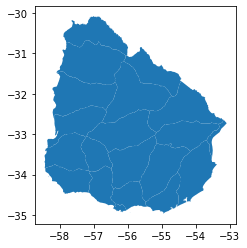

In [23]:
uru_geom.plot()

<AxesSubplot:>

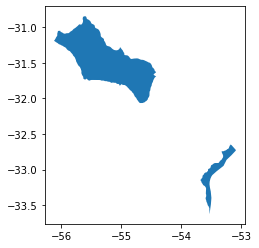

In [24]:
uru_geom[uru_geom['NAME_1'] == 'Rivera'].plot()

La geometría de Rivera en la tabla incluye parte de la Laguna Merín. Quitamos esa información:

In [25]:
uru_geom.loc[uru_geom['NAME_1'] == 'Rivera', 'geometry'] = \
    uru_geom.loc[uru_geom['NAME_1'] == 'Rivera', 'geometry'].values[0][1]

<AxesSubplot:>

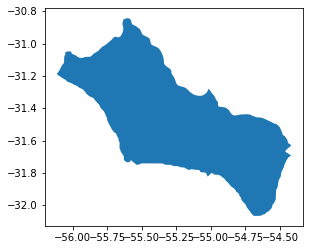

In [26]:
uru_geom.loc[uru_geom['NAME_1'] == 'Rivera', 'geometry'].plot()

<a id='section_4'></a>

## Mapas

### 4. Total de casos activos

Antes de construir los mapas, hay que preparar los dataframes (uru_pobl_df y uru_geom). Para esto se utiliza la clase **DataFramePrepper**.

In [27]:
prepper = DataFramePrepper(info_df=uru_pobl_df, geom_df=uru_geom)

La tabla de datos necesita tener forma "wide" con las locaciones en el index y las fechas en las columnas. El método *prep_info_df* se encarga de esa transformación, con el parámetro *category* representando la categoría de valores que queremos graficar. 

In [28]:
ready_info_df = prepper.prep_info_df(category='Casos activos', col_dates='Fecha', 
                                col_location='Territorio', col_categories='Indicador', 
                                col_values='Valor', long=True)
ready_info_df.head()

date,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,...,2020-11-15,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-21,2020-11-22,2020-11-23,2020-11-24
location,,,,,,,,,,,,,,,,,,,,,
Artigas,0,0,0,0,0,0,0,0,0,0,...,9,8,10,10,10,14,14,13,15,15
Canelones,37,37,34,32,31,29,27,27,25,26,...,87,95,105,115,127,139,158,160,166,181
Cerro Largo,0,0,0,0,0,0,0,0,0,0,...,73,75,76,79,72,77,73,65,51,46
Colonia,4,5,5,5,5,5,5,5,5,5,...,41,41,48,51,52,45,49,45,40,39
Durazno,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


El método *prep_geom_df* toma las columnas con los nombres de las locaciones ('NAME_1') y de los vectores geoespaciales ('geometry'). Retorna una tabla con las locaciones en el index.

In [29]:
ready_geom_df = prepper.prep_geom_df(location_col='NAME_1', geometry_col='geometry')
ready_geom_df.head()

,geometry
location,
Artigas,"POLYGON ((-56.97895 -30.09347, -56.95917 -30.0..."
Canelones,"MULTIPOLYGON (((-55.91930 -34.93597, -55.91930..."
Cerro Largo,"POLYGON ((-54.09551 -31.90558, -54.08907 -31.9..."
Colonia,"MULTIPOLYGON (((-57.88820 -34.47097, -57.88820..."
Durazno,"POLYGON ((-55.42105 -32.40704, -55.40257 -32.4..."


La función *merge_info_geom* combina las tablas *ready_info_df* y *ready_geom_df*.

In [30]:
merged_df = prepper.merge_info_geom()
merged_df.head()

,geometry,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,...,2020-11-15,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-21,2020-11-22,2020-11-23,2020-11-24
location,,,,,,,,,,,,,,,,,,,,,
Artigas,"POLYGON ((-56.97895 -30.09347, -56.95917 -30.0...",0,0,0,0,0,0,0,0,0,...,9,8,10,10,10,14,14,13,15,15
Canelones,"MULTIPOLYGON (((-55.91930 -34.93597, -55.91930...",37,37,34,32,31,29,27,27,25,...,87,95,105,115,127,139,158,160,166,181
Cerro Largo,"POLYGON ((-54.09551 -31.90558, -54.08907 -31.9...",0,0,0,0,0,0,0,0,0,...,73,75,76,79,72,77,73,65,51,46
Colonia,"MULTIPOLYGON (((-57.88820 -34.47097, -57.88820...",4,5,5,5,5,5,5,5,5,...,41,41,48,51,52,45,49,45,40,39
Durazno,"POLYGON ((-55.42105 -32.40704, -55.40257 -32.4...",0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


La clase *ChoroMapBuilder* contiene los métodos gráficos, de manipulación de fechas y de exportación necesarios para crear los mapas. Su método principal es *make_map*. Éste llama a todos los otros métodos necesarios para obtener un mapa animado.

In [31]:
builder = ChoroMapBuilder(merged_df)

In [32]:
builder.make_map(title="Total de casos activos de COVID-19 por departamento", 
                        subtitle='Fuente: SINAE - https://catalogodatos.gub.uy/dataset/sinae01-covid19', 
                        unit='Número de casos activos', 
                        fig_size=(10,8), lang='es', save_name='casos_activos', fps=6)

<a id='section_5'></a>

### 5. Tasa de casos activos

In [33]:
ready_info_df = prepper.prep_info_df(category='Casos activos', col_dates='Fecha', 
                               col_location='Territorio', col_categories='Indicador',
                               col_values='Valor_tasa', long=True)

In [34]:
merged_df = prepper.merge_info_geom()

In [35]:
builder = ChoroMapBuilder(merged_df)

In [36]:
builder.make_map(title="Tasa de casos activos de COVID-19 por departamento", 
                        subtitle='Fuente: SINAE - https://catalogodatos.gub.uy/dataset/sinae01-covid19', 
                        unit='Casos activos cada 100.000 personas', 
                        fig_size=(10,8), lang='es', save_name='activos_tasa', fps=6)

<a id='section_6'></a>

### 6. Total de fallecidos

In [37]:
ready_info_df = prepper.prep_info_df(category='Fallecidos', col_dates='Fecha', 
                               col_location='Territorio', col_categories='Indicador',
                               col_values='Valor', long=True)

In [38]:
merged_df = prepper.merge_info_geom()

In [39]:
builder = ChoroMapBuilder(merged_df)

In [40]:
builder.make_map(title='Total de fallecidos por COVID-19 por departamento',
                          subtitle='Fuente: SINAE - https://catalogodatos.gub.uy/dataset/sinae01-covid19',
                          unit='Número de fallecidos', lang='es', save_name='fallecidos_total', 
                          fig_size=(10,8), fps=6, color='Reds')

<a id='section_7'></a>

### 7. Tasa de fallecidos

In [41]:
ready_info_df = prepper.prep_info_df(category='Fallecidos', col_dates='Fecha', 
                               col_location='Territorio', col_categories='Indicador',
                               col_values='Valor_tasa', long=True, roll_avg=True)

In [42]:
merged_df = prepper.merge_info_geom()

In [43]:
builder = ChoroMapBuilder(merged_df)

In [44]:
builder.make_map(title='Tasa de fallecidos por COVID-19 cada 100.000 personas',
                    subtitle='Fuente: SINAE - https://catalogodatos.gub.uy/dataset/sinae01-covid19',
                    unit='Fallecidos cada 100.000 personas', fig_size=(10,8), lang='es', 
                    save_name='fallecidos_tasa', fps=6, color='Reds')